In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import katpoint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from astropy.time import Time
import os
from IPython.core.display import display, HTML

In [3]:
#create a variety of coloured markers.  After a while the plots get really crowded,
#but you can add on to this if you like.
markers = []
colors = ['b','g','r','c','m','y','k']
pointtypes = ['o','*','x','^','s','p','h','+','D','d','v','H','d','v']
for point in  pointtypes:
    for color in colors:
        markers.append(str(color+point))

This notebook can be used each week to plan the scheduling of observations on MeerKAT. 

It will generate an obs table, with times in SAST, that can be used to block off times in the Google calendar

See https://en.wikipedia.org/wiki/Sidereal_time for a discussion of siderial time

Some useful points to check your scheduling sanity:
* The RA of a target is equal to the LST when the target is at its highest elevation (when it tranits)... this is useful because if you are doing scheduling the best is to observe equally on either side of this time
* LST will change by roughy 4 mins per day ... so a target will transit 4 mins earlier each day
* MeerKAT LST matches SAST on roughly 30 Sep each year ... it is 6 hrs after SAST on about 30 Dec, 12 hrs difference in March and 6 hrs before in June 

You can also look at the following pyephem doc page for more ways to use the ant.ref_observer object. http://rhodesmill.org/pyephem/quick.html

Link to the MeerKAT observation calendar

https://calendar.google.com/calendar/embed?src=ska.ac.za_hd1ilp7tkoffoa9f2gh0j6l0q8%40group.calendar.google.com&ctz=Africa/Johannesburg

In [4]:
ant = katpoint.Antenna('Ref, -30:42:39.8, 21:26:38.0, 1035.0') # the MeerKAT reference point
ant.ref_observer.horizon = '20:00:00' # horizon set to 20 degrees
SAST = matplotlib.dateutil.relativedelta.relativedelta(hours=2) # useful to convert to SAST (UTC + 2)

In [5]:
# catalogue cell

cat = katpoint.Catalogue()
cat.antenna = ant
#cat.add(file('/home/tony/Desktop/PythonScripts/KAT/SCI-20181016-FC-01_J1210-5226.csv'))
#cat.add(file('/home/tony/Desktop/PythonScripts/KAT/SCI-20181016-FC-01_J1210-5226.csv'))
#cat.add(file('/home/tony/Desktop/PythonScripts/KAT/SCI-20180516-PW-01_MAXI_J1820+070.csv'))
cat.add(file('/home/tony/Desktop/PythonScripts/KAT/SCI-20180624-FC-01_J0232-4420.csv'))

In [6]:
# start time cell

# select the timestamp to be used to generate the obs table 
# comment out one of the following two lines
#start_timestamp = katpoint.Timestamp() # use NOW as the start time for the obs table
start_timestamp = katpoint.Timestamp('2019-01-13 00:00:00') # use a specific time as the start time (in UTC ... )

In [7]:
# pyephem version of the katpoint timestamp for the ref_observer object
start_ed = start_timestamp.to_ephem_date()

In [8]:
# generate an html table for displaying
# only the first 16 characters [:16] are shown for the time string
# for readability

h = '<table>'
h += "<tr><td colspan='4'>Obs table for %s</td></tr>"%str(start_timestamp+7200)[:16]
h += "<tr><td>Target<td>Next Rise<td>Next Transit<td>Next Set</tr>"
for tar in cat.targets:
    try:
        rise_time = str((ant.ref_observer.next_rising(tar.body,start_ed).datetime()+SAST))[:16]
    except:
        rise_time = 'source does not rise'
        
    try:
        transit_time = str((ant.ref_observer.next_transit(tar.body,start_ed).datetime()+SAST))[:16]
    except:
        transit_time = 'source does not transit'
    try:
        set_time = str((ant.ref_observer.next_setting(tar.body,start_ed).datetime()+SAST))[:16]
    except:
        set_time = 'source does not set'
    h += '<tr><td> %s | %s <td> %s <td> %s <td> %s </tr>'%(tar.name,tar.aliases,
                                rise_time,
                                transit_time,
                                set_time)
h += "<tr><td colspan='4'>These times are in SAST</td></tr>"
h += "</table>"
display(HTML(h))

Obs table for 2019-01-13 02:00
These times are in SAST


J0232.2-4420 is above 20 degrees between LST 20.54 and 8.57 
J0408-6545 is above 20 degrees between LST 8.91 and 8.87 
J0203-4349 is above 20 degrees between LST 20.04 and 8.07 


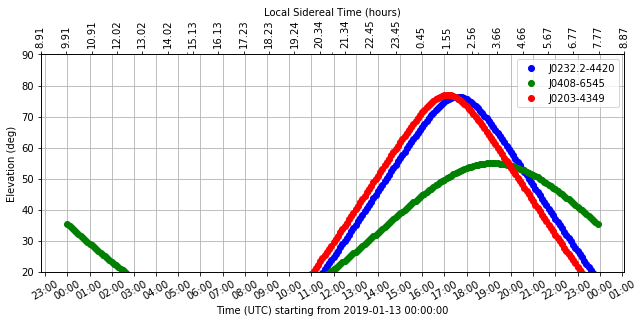

In [9]:
target = cat.targets[0]
t = start_timestamp.secs + np.arange(0, 24. * 60. * 60., 360.)
lst = katpoint.rad2deg(target.antenna.local_sidereal_time(t)) / 15

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 4)
plt.subplots_adjust(right=0.8)
lines = list()
labels = list()
count = 0
fontP = FontProperties()
fontP.set_size('small')

for target in cat.targets:
    count = count + 1
    elev = katpoint.rad2deg(target.azel(t)[1])
    timestamps = Time(t, format='unix')
    myplot,= plt.plot_date(timestamps.datetime,elev, markers[count-1], linewidth = 0, label=target.name)
    lines.append(myplot)
    labels.append(target.name)
    lst_rise = lst[np.where(elev>20)[0][0]]
    lst_set = lst[np.where(elev>20)[0][-1]]
    print('%s is above 20 degrees between LST %.2f and %.2f '%(target.name, lst_rise, lst_set))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=range(24),interval=1))
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)
plt.ylim(20,90)
plt.grid()
plt.legend()
plt.ylabel('Elevation (deg)')
plt.xlabel ('Time (UTC) starting from %s'%start_timestamp)
ax2 = ax1.twiny()
ax2.xaxis.set_major_locator(MaxNLocator(24))
minorLocator = MultipleLocator(0.25)
ax2.xaxis.set_minor_locator(minorLocator)
new_ticks = plt.xticks(
    np.linspace(0,1,24),
    np.round(lst[np.linspace(1, len(lst), num=24, dtype = int)-1], 2),
    rotation = 'vertical')
plt.xlabel('Local Sidereal Time (hours)')
